# Imports

In [51]:
import time
import math
import random
import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

# Create graph

In [52]:
start_coords = (53.472075, -2.238855) # The Dalton Building

In [53]:
# Get data from open street maps with OSMnx
G = ox.graph_from_point(start_coords, dist=3000, network_type="drive", simplify=True)

In [54]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# General Node Class

In [55]:
class Node():
    '''
    Generic node class to store graph nodes.

    Attributes:
        node_id: int = The node's unique id number from OSMnx
        cost_to_reach: float = Stores the cost (time) to reach to node from the starting node
        depth: int = Stores the depth in the graph of the node
        parent: Node = Stores the node which lead to this node in the search
    '''
    def __init__(self, node_id: int, cost_to_reach: float = 0, parent=None, heuristic_val: float = 0):
        self.node_id: int = node_id
        self.cost_to_reach: float = cost_to_reach
        self.heuristic_value: float = heuristic_val
        self.depth: int = 0
        
        self.parent = parent

    def path_to(self):
        ''' Recursively find the set of nodes from the start node to this one and returns a list a their IDs. '''
        if self.parent is None: return []
        
        return self.parent.path_to() + [self.node_id]
                
    def __str__(self):
        return f"<class Node Object>, ID: {self.node_id}"
    
    def __repr__(self):
        return f"({self.__str__()})"
    
    def __eq__(self, other):
        # Compare equality based on the node_id
        if isinstance(other, Node):
            return self.node_id == other.node_id
        return False

    def __hash__(self):
        return hash(self.node_id)

# Setup

### Setup figure and axes for drawing the graph

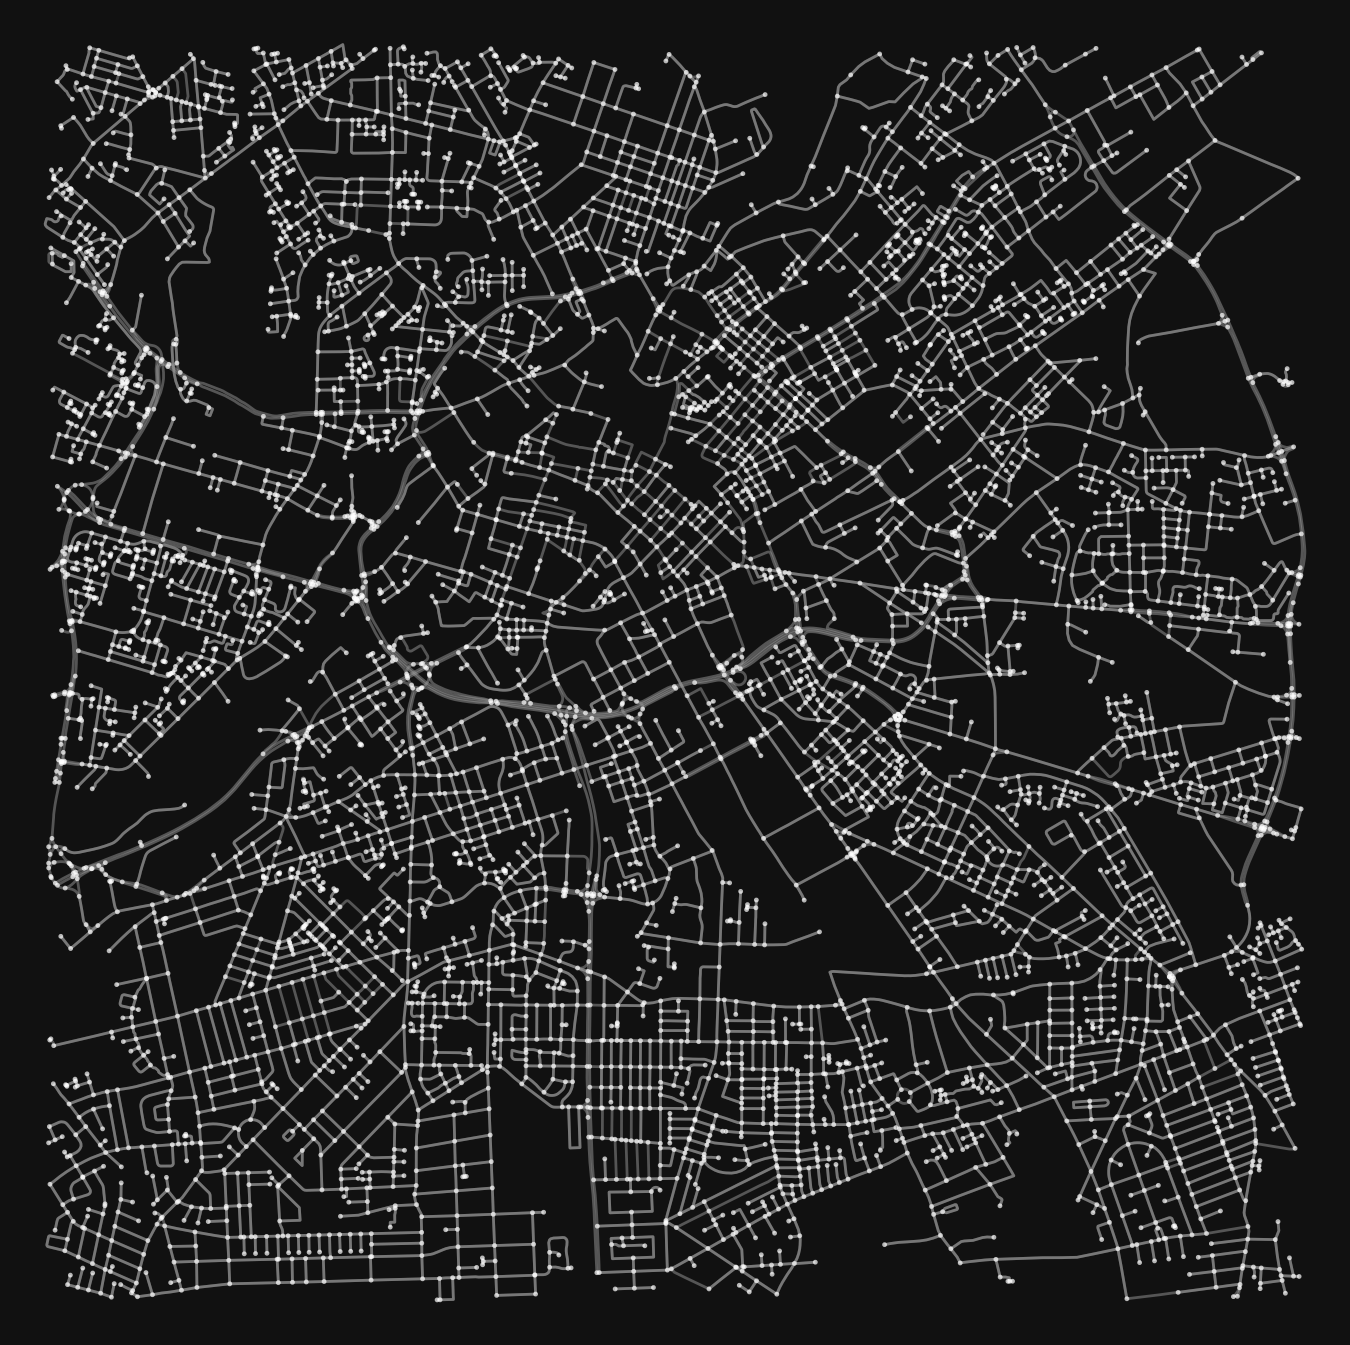

In [56]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 7),facecolor="#111111");
ax.set_facecolor("#111111")

# Remove margins
ax.margins(0)
plt.tight_layout(pad=0)

fig, ax, scatter = ox.plot_graph(G, ax=ax, node_size=3, node_alpha=0.7, edge_alpha=0.5);

In [57]:
# Create list of nodes
nodes = [Node(node_id) for node_id in G.nodes()]
num_points = len(nodes)

In [58]:
# Create a dictionary of adjacent nodes for look-up.
adj_dict = {n: list(adjacent_node_dict.keys()) for n, adjacent_node_dict in G.adjacency()}

### Ensure all roads speeds have speeds (as floats)

In [59]:
'''
Streets speeds are strings in the format: "x mph" and some are lists of two speeds e.g. ["x mph", "y mph"]
Here these are converted to floats and the speeds are averaged when two are given. Finally any missing speeds
are filled in with the mean speed from the other roads.
'''

from sklearn.impute import SimpleImputer

def handle_maxspeed(value) -> float:
    ''' Takes a maxspeed value and converts it to a single float. '''
    if isinstance(value, str):
        # If the value is a string it splits the first part and casts it to an int
        return int(value.split()[0])
    if isinstance(value, (list, tuple)):
        # If the value is a list it splits off the first part of each, turns it into an int and returns the mean
        return np.mean([int(speed.split()[0]) for speed in value])
    if isinstance(value, (int, float)):
        return float(value)
    raise Exception(f"Unknown data type in maxspeed column: {type(value)}")

# Apply the function to the "maxspeed" column
gdf_edges["maxspeed"] = gdf_edges["maxspeed"].apply(handle_maxspeed)


# Fill in missing speeds with the mean.
gdf_edges[["maxspeed"]] = SimpleImputer().fit_transform(gdf_edges[["maxspeed"]])

### Helper functions

In [60]:
def mph_to_mps(speed_mph: float) -> float:
    ''' Convert speed from mph to metres per second. '''
    return (speed_mph * 1609.344) / 60**2

def time_between(start_node_id: int, end_node_id: int) -> float:
    '''
    Locates the edge between two nodes (based on their ID) and returns the time taken to
    drive between them in seconds.
    '''
    edge_between_nodes = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")

    road_speed_mph = edge_between_nodes["maxspeed"][0].item()
    road_length_m = edge_between_nodes["length"][0].item()

    return road_length_m / mph_to_mps(road_speed_mph) 

def format_time(seconds: float) -> str:
    '''
    Converts time in seconds to a readable string in hours, minutes and seconds.
    '''
    return time.strftime(f"%H:%M:{round(seconds%60, 3)}s", time.gmtime(seconds))

# Searching

In [61]:
class SearchType(Enum):
    BFS = 0
    DFS = 1
    UCS = 2
    A_STAR = 3

class SearchClass:
    '''
    General class for searching searching for paths between two nodes. Implements breadth-first search,
    depth-first search, uniform-cost search and A*.

    Attributes:
        start: Node = The node to begin search from
        destination: Node = The node to end on

    '''
    def __init__(self, start_node: Node, destination_node: Node, heuristic_func: Callable = None) -> None:
        self.start: Node = start_node
        self.destination: Node = destination_node
        self.done: bool = False
        self.no_path: bool = False

        self.open: list = [start_node]
        # Perhaps closed could be a set rather than a list
        self.closed: list = []

        self.current_node: Node = start_node

        self.start.heuristic_value = heuristic_func(start_node, destination_node) if heuristic_func is not None else 0
        self.heuristic_func: Callable = heuristic_func

        self.num_visited = 0


    def _reset(self) -> None:
        ''' Reset the object's attributes so no data from old searches leak into new search.'''
        self.closed = []
        self.done = False
        self.no_path = False
        self.heuristic_dict = {self.start: self.heuristic_func(self.start, self.destination)} if self.heuristic_func is not None else {}
        self.open = [self.start]
        self.current_node = self.start
        self.num_visited = 0

    def run_search(self, search_type: SearchType, heuristic_func: Callable = None) -> None:
        '''
        Runs a full search between the start and destination nodes using a given search algorithm.
        '''
        self._reset()

        if heuristic_func: self.heuristic_func = heuristic_func
        if search_type == SearchType.A_STAR and self.heuristic_func == None:
            raise Exception("Heuristic function is required to run A* search.")
        
        while not self.done:
            self.search_step(search_type=search_type)

    def search_step(self, search_type: SearchType) -> Node:
        '''
        Performs one step of a search algorithm.
        '''      
        next_node = self.pick_node(search_type)
        self.done = (next_node == self.destination) or (next_node is None)
        if next_node is None: return
        self.open.extend(
            [Node(node_id,
                    parent = next_node,
                    cost_to_reach = (next_node.cost_to_reach + self.calc_path_time([next_node.node_id, node_id]) if search_type in [SearchType.UCS, SearchType.A_STAR] else np.nan), 
                    heuristic_val = self.heuristic_func(Node(node_id), self.destination) if search_type == SearchType.A_STAR else 0
                  ) for node_id in adj_dict[next_node.node_id] if Node(node_id) not in self.closed])
        
        self.closed.append(next_node)
        self.current_node = next_node

        return next_node
    
    def pick_node(self, search_type: SearchType) -> Node:
        ''' Selects a node to visit next from the open set based on the type of search being performed. '''
        if len(self.open) == 0:
            self.no_path = True
            return None
        
        if search_type == SearchType.BFS:
            return self.open.pop(0)
        if search_type == SearchType.DFS:
            return self.open.pop(-1)
        if search_type == SearchType.UCS:
            self.open.sort(key=lambda node: node.cost_to_reach)
            return self.open.pop(0)
        if search_type == SearchType.A_STAR:
            # Perhaps insert nodes rather than sorting the whole list ?
            self.open.sort(key=lambda node: node.heuristic_value + node.cost_to_reach)
            return self.open.pop(0)
        
    def calc_path_time(self, path: list) -> float:
        '''
        Takes path as a list of node_id's and calculates the total time to traverse from
        the first node to the last via each node in the path. This assumes that there is
        a valid edge between each node in the path. Returns the time in seconds.
        '''
        time = np.sum([time_between(path[i], path[i+1])
                for i in range(len(path) - 1)])

        return time
    
    def describe_path(self, path: list):
        '''
        Takes path as a list of node_id's and returns a list of the unique streets traversed in order
        as the path is followed.
        '''
        path_list = [str(list(gdf_edges.xs(path[i], level="u").xs(path[i + 1], level="v")["name"])[0]) 
                     for i in range(len(path) - 1)]

        return pd.Series(path_list).unique()

# Visualising

In [62]:
# Visualisation code

# Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

def update_graph_visuals(current_node: Node, closed_set: list, destination_node: Node):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''
    global node_index_map
    
    sizes = [2 for i in range(num_points)]
    colours = ["#FFFFFF" for i in range(num_points)]
    
    # Loop through all closed (visited) nodes and set them to yellow and size 10
    for node in closed_set:
        sizes[node_index_map[node]] = 5
        colours[node_index_map[node]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[destination_node]] = "#FF00FF"
    sizes[node_index_map[destination_node]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"
    
    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

class SearchClass(SearchClass):
    '''
    Extend search class with visualisation code.
    '''
    def animate_search(self, search_type: SearchType) -> None:
        # Animation function
        def animate(frame):
            next_node = self.search_step(search_type)
            self.num_visited += 1
            update_graph_visuals(next_node, self.closed, self.destination)
            return scatter
        
        # Frame generator: Stops yielding when .done
        def frame_generator():
            frame = 0
            while not self.done:
                yield frame
                frame += 1

        self._reset()
        
        # Plot the start and destination nodes
        ax.scatter(
            [G.nodes[self.start.node_id]['x'], G.nodes[self.destination.node_id]['x']],  # x-coordinates
            [G.nodes[self.start.node_id]['y'], G.nodes[self.destination.node_id]['y']],  # y-coordinates
            s=[10, 50],  # Sizes: Smaller for start, larger for destination
            c=["#00FF00", "#FF00FF"],  # Colors: Green for start, purple for destination
            zorder=3  # Ensure this is drawn on top
        )

        # Create the animation using the generator
        ani = animation.FuncAnimation(fig, animate, frames=frame_generator, interval=1, save_count=num_points)

        # Save the animation
        ffmpeg_writer = animation.FFMpegWriter(fps=5)
        print(f"Saving output to {search_type.name + "_manchester.mp4"}.")
        ani.save(search_type.name + "_manchester.mp4", writer=ffmpeg_writer, dpi=200)
        print(f"Visited {self.num_visited} nodes")

    def display_final(self) -> None:
        if len(self.closed) <= 0:
            raise Exception("Must execute run_search method before displaying.")
        
        path = self.closed[-1].path_to()
        print("Final path:", self.describe_path(path))
        print(f"Path travel time: {format_time(self.calc_path_time(path))}.")
    
        # Get node coordinates from the graph
        node_x = [G.nodes[node.node_id]['x'] for node in nodes]
        node_y = [G.nodes[node.node_id]['y'] for node in nodes]

        # Set default sizes and colors
        sizes = [1 for _ in range(num_points)]
        colours = ["#DDDDDD" for _ in range(num_points)] 

        # Extract start and destination node positions
        start_x, start_y = G.nodes[self.start.node_id]['x'], G.nodes[self.start.node_id]['y']
        dest_x, dest_y = G.nodes[self.destination.node_id]['x'], G.nodes[self.destination.node_id]['y']

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(7,7), facecolor="#111111")
        ax.set_facecolor("#111111")
        ax.axis('off')
        
        # Remove margins
        ax.margins(0)
        plt.tight_layout(pad=0)

        # Plot all edges (graph edges) in grey
        for u, v, data in G.edges(data=True):
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#777777", alpha=1, lw=1, zorder=1)

        # Highlight path edges
        full_path = [self.start.node_id] + path  # Include start node explicitly
        for i in range(len(full_path) - 1):  # Iterate through consecutive nodes in the path
            u, v = full_path[i], full_path[i + 1]
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#FFFF00", lw=2, alpha=1, zorder=3)  # Highlighted path edges

        # Plot all other nodes with default sizes and colors
        ax.scatter(node_x, node_y, s=sizes, c=colours, zorder=2)

        # Plot nodes on the path
        for node_id in path:
            x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
            ax.scatter(x, y, s=6, c="#FFFF00", zorder=4)

        # Plot visited nodes
        for node in self.closed:
            if node.node_id in path: next
            x, y = G.nodes[node.node_id]['x'], G.nodes[node.node_id]['y']
            ax.scatter(x, y, s=1, c="#CCCC55", zorder=4)    

        # Plot the start node on top (in red)
        ax.scatter(start_x, start_y, s=50, c="#FF0000", label="Start", zorder=5)

        # Plot the destination node on top (in purple)
        ax.scatter(dest_x, dest_y, s=50, c="#FF00FF", label="Destination", zorder=5)

        # Add legend for clarity
        ax.legend(facecolor="#222222", labelcolor="#FFFFFF", loc="upper right")

        plt.show()

# Heuristics

In [63]:
def euclid_distance(start_node: Node, end_node: Node) -> float:
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return (((x_start - x_end)*0.01745*math.cos(y_start))**2 + ((y_start - y_end*111319))**2)**0.5

def manhattan_distance(start_node: Node, end_node: Node) -> float:
    '''
    Manhattan distance is not an admissible heuristic in the context of driving as roads can have different speed limits
    which means a node may be given a large heuristic value as it is far from the target but it may be a fast road and thus
    the heuristic will overestimate the true cost.        
    '''
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    # x and y are given in latitude/longitude degrees so they need to be converted to metres
    return abs(x_start - x_end)*0.01745*math.cos(y_start) + abs(y_start - y_end)*111319

max_speed = mph_to_mps(gdf_edges["maxspeed"].max())
def distance_normalised(start_node: Node, end_node: Node) -> float:
    '''
    A admissible heuristic can be created by dividing the straight-line distance to the goal by the maximum speed on the roads.
    This ensures that the heuristic is maximally optimistic i.e. assuming the car travels directly at max speed to the goal.
    With an optimistic heuristic like this the cost will never be overestimated.
    '''
    global max_speed
    return manhattan_distance(start_node, end_node) / max_speed

# Running

In [64]:
# Start at the Dalton Building
start_node = Node(ox.distance.nearest_nodes(G, Y=start_coords[0], X=start_coords[1]), cost_to_reach=0)

# Random destination
destination_node = nodes[2482] #random.choice(nodes)

print(f"Navigating from node {start_node.node_id} to node {destination_node.node_id}.")

Navigating from node 3356365 to node 307864030.


In [65]:
searcher = SearchClass(start_node, destination_node, heuristic_func=distance_normalised)

BFS search took 00:01:33.428s
Visited 31935 nodes.
Final path: ['Charles Street' 'Sackville Street' 'Whitworth Street' 'Aytoun Street'
 'Auburn Street' 'London Road' 'Store Street' 'Old Mill Street'
 'Bradford Road' 'Varley Street' 'Sandal Street' 'Stracey Street'
 'Sabden Close']
Path travel time: 00:05:38.446s.


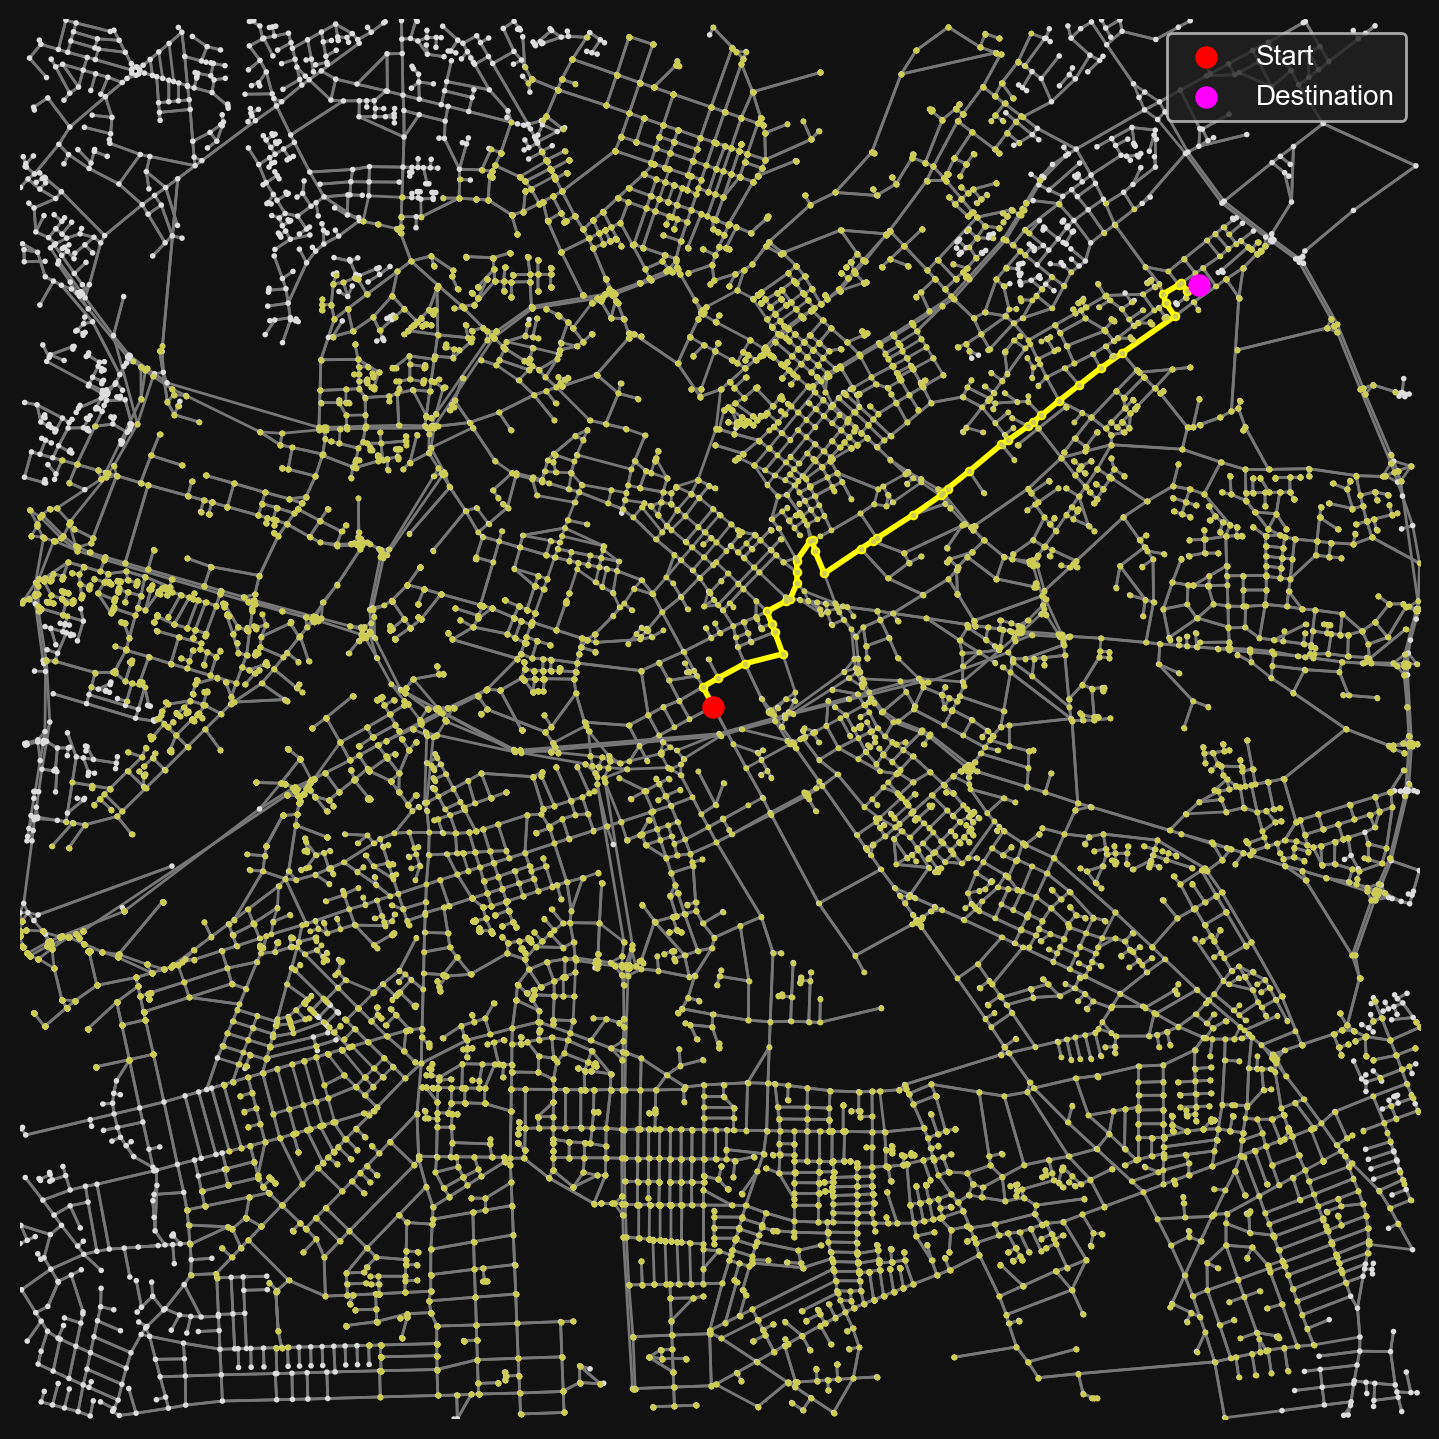

DFS search took 00:00:2.144s
Visited 4848 nodes.
Final path: ['Oxford Road' 'Rosamond Street West' 'Boundary Lane' 'Freeman Square'
 'Fenwick Street' 'Salutation Street'
 "['Upper Medlock Street', 'Poynton Street']" 'Epping Street'
 'Ruby Street' 'Arnott Crescent' 'Rial Place' 'Eden Close'
 "['Aquarius Street', 'Botham Close']" 'Bronte Street' 'Greenheys Lane'
 'Princess Road' 'Moss Lane East' 'Raby Street' 'Barnhill Street'
 'Great Western Street' 'Claremont Road' 'Hartington Street'
 'Alison Street' 'Rosebery Street' 'Beresford Street' 'Bowes Street'
 'Platt Lane' 'Lloyd Street South' 'Garswood Road' 'Clinton Avenue'
 'Parkside Road' 'Regent Avenue' 'Yew Tree Avenue' 'Laurel Avenue'
 'Caythorpe Street' 'Cowesby Street' 'Greame Street' 'Broadfield Road'
 'Kensington Street' 'Tyldesley Street' 'Tommy Johnson Walk'
 'Upper Lloyd Street' 'Horace Barnes Close' 'Edith Avenue'
 'Burdith Avenue' 'Thornton Road' 'Rosedale Road' 'Horton Road'
 'Boscombe Street' 'Parkfield Street' 'Worthing Str

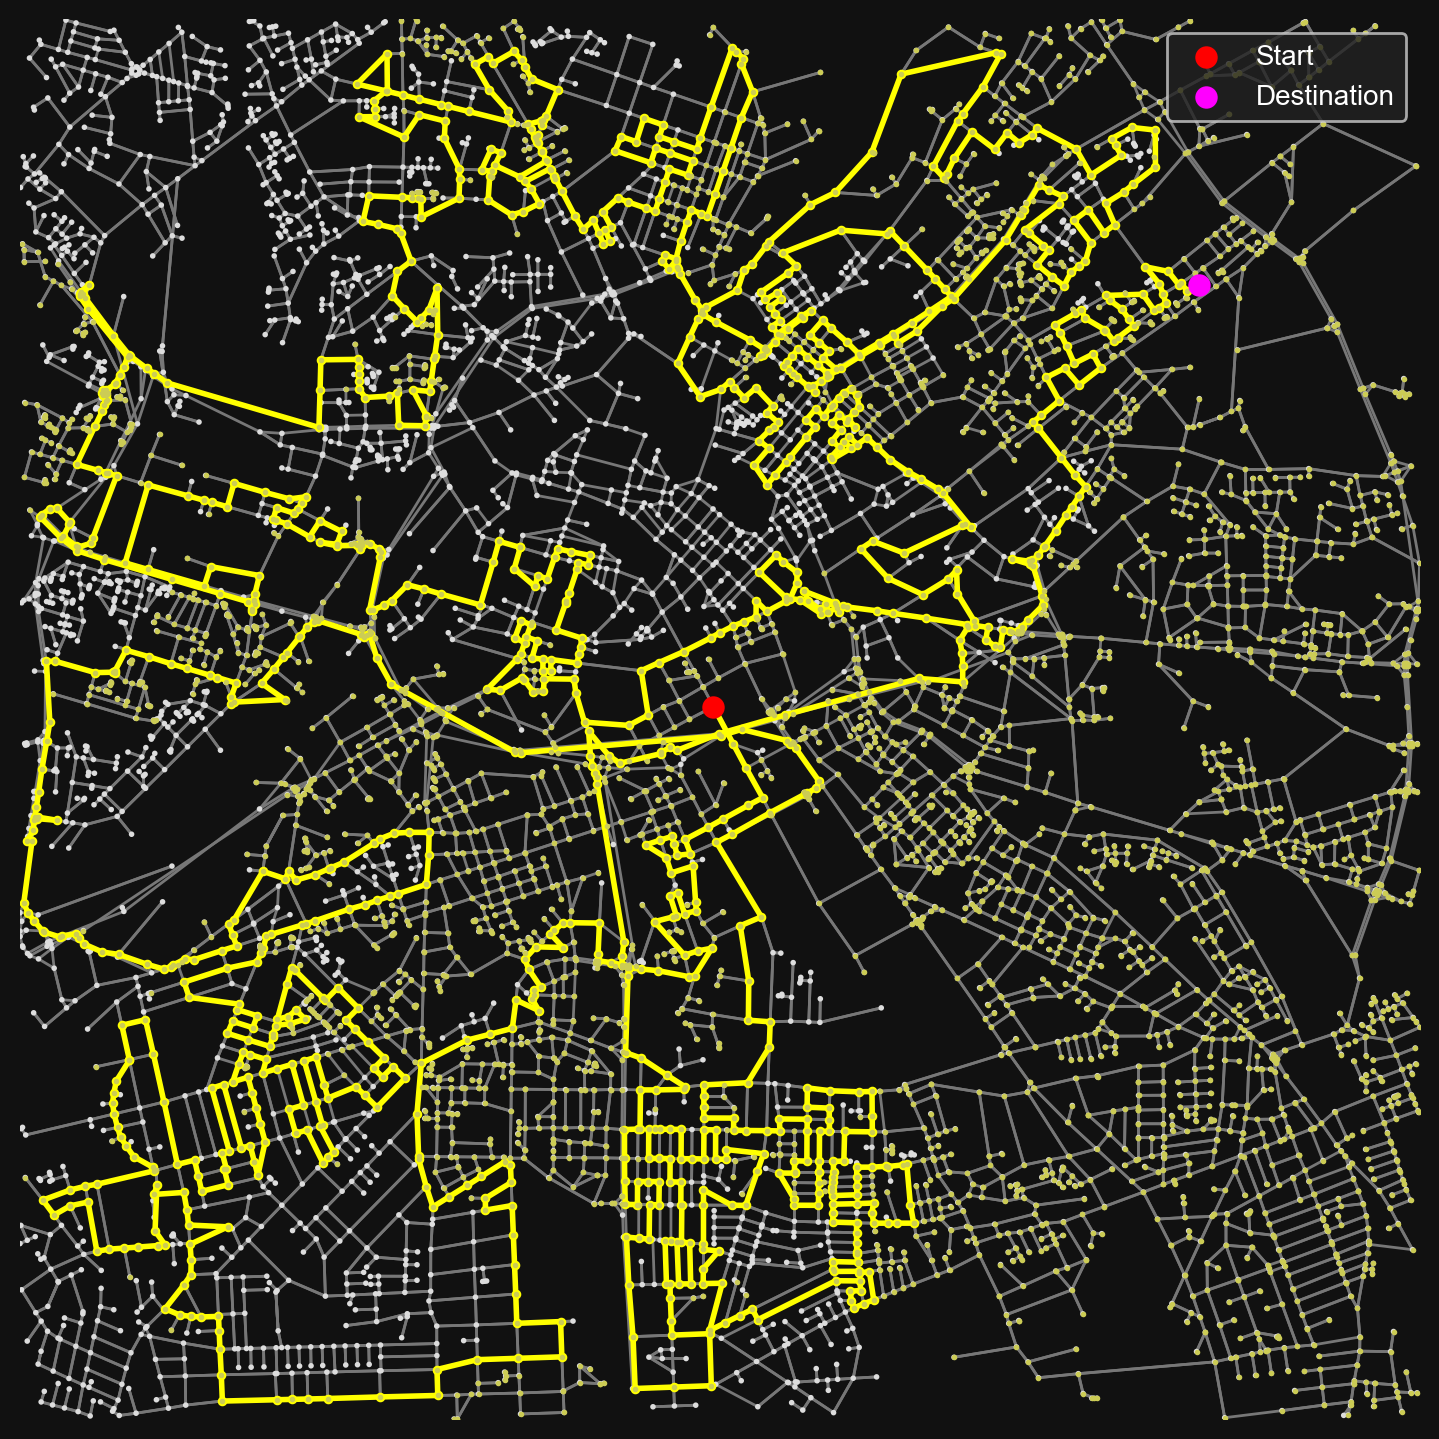

UCS search took 00:00:18.017s
Visited 11528 nodes.
Final path: ['Charles Street' 'Princess Street' 'Whitworth Street' 'Fairfield Street'
 'Travis Street' 'Adair Street' 'Great Ancoats Street' 'Pollard Street'
 'Carruthers Street' 'Old Mill Street' 'Bradford Road' 'Varley Street'
 'Sandal Street' 'Stracey Street' 'Sabden Close']
Path travel time: 00:04:59.311s.


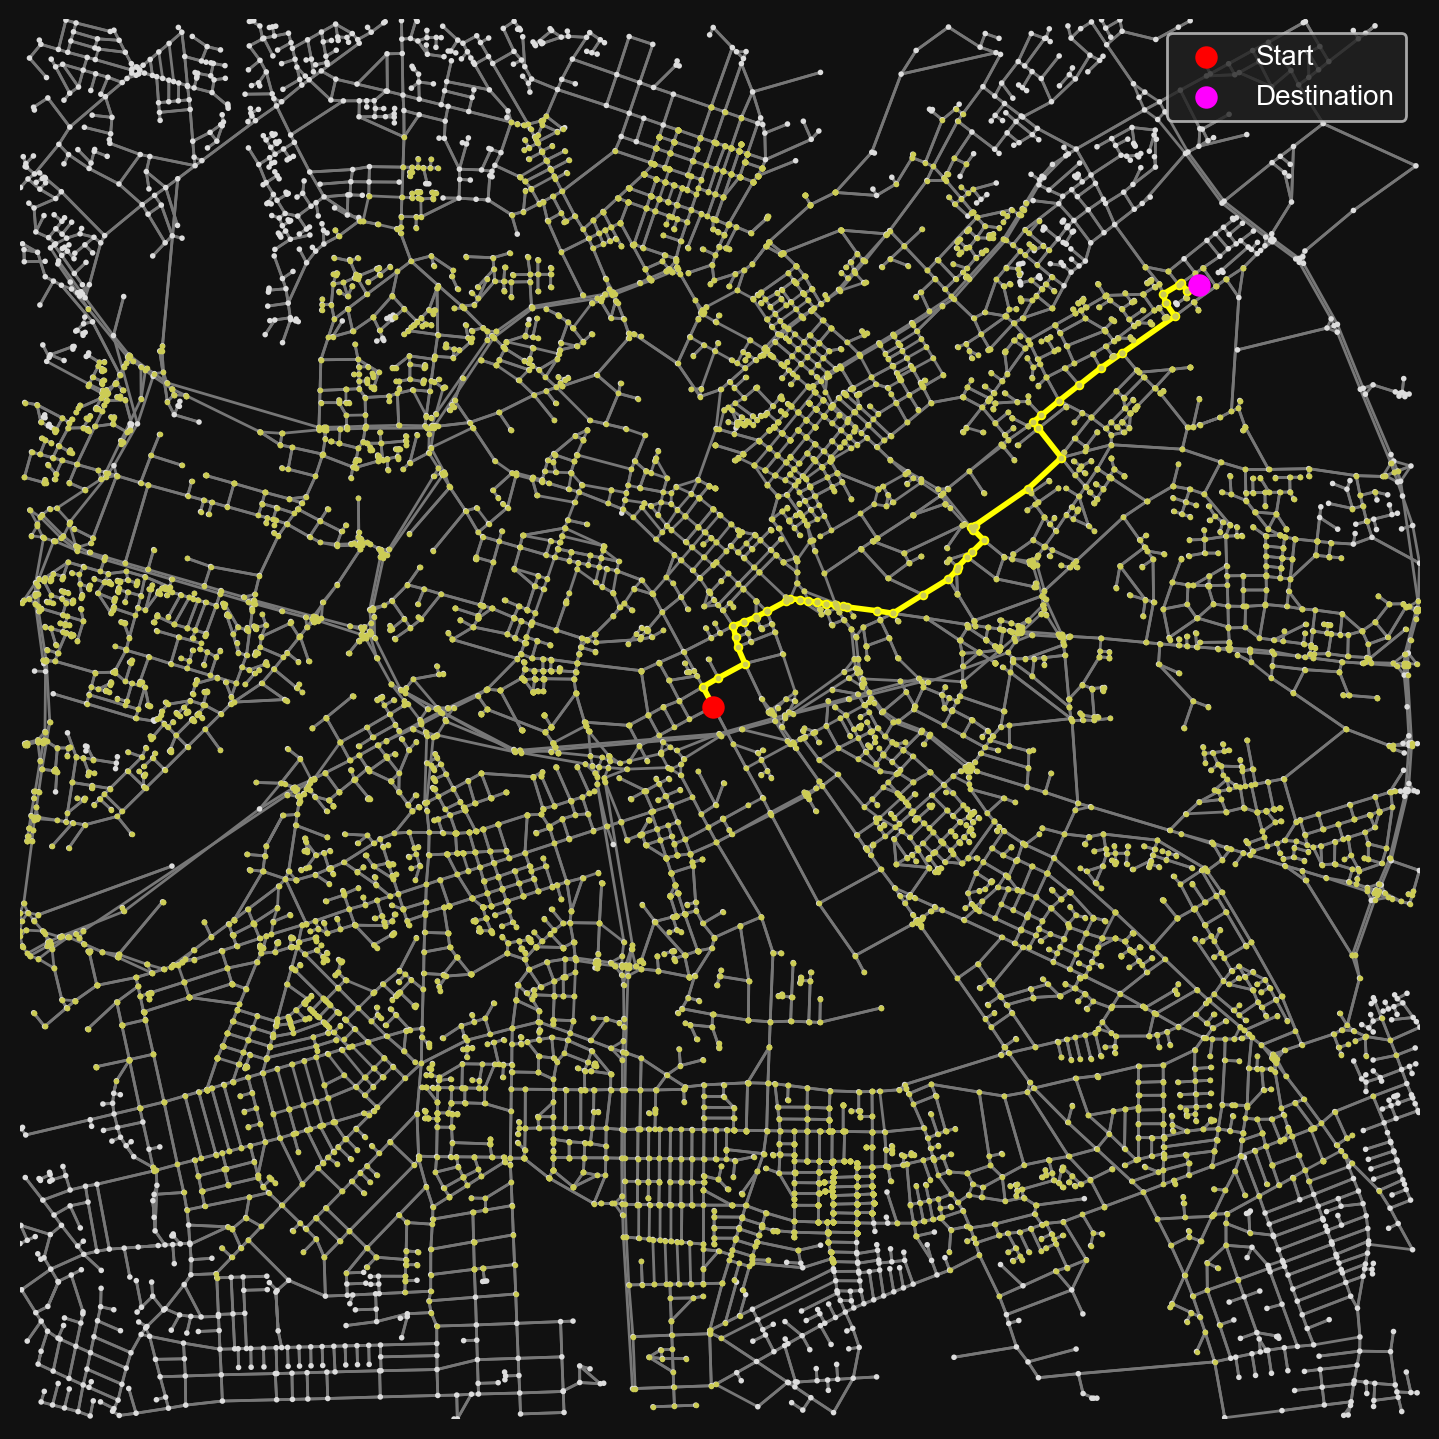

A_STAR search took 00:00:6.419s
Visited 6161 nodes.
Final path: ['Charles Street' 'Princess Street' 'Whitworth Street' 'Fairfield Street'
 'Travis Street' 'Adair Street' 'Great Ancoats Street' 'Pollard Street'
 'Carruthers Street' 'Old Mill Street' 'Bradford Road' 'Varley Street'
 'Sandal Street' 'Stracey Street' 'Sabden Close']
Path travel time: 00:04:59.311s.


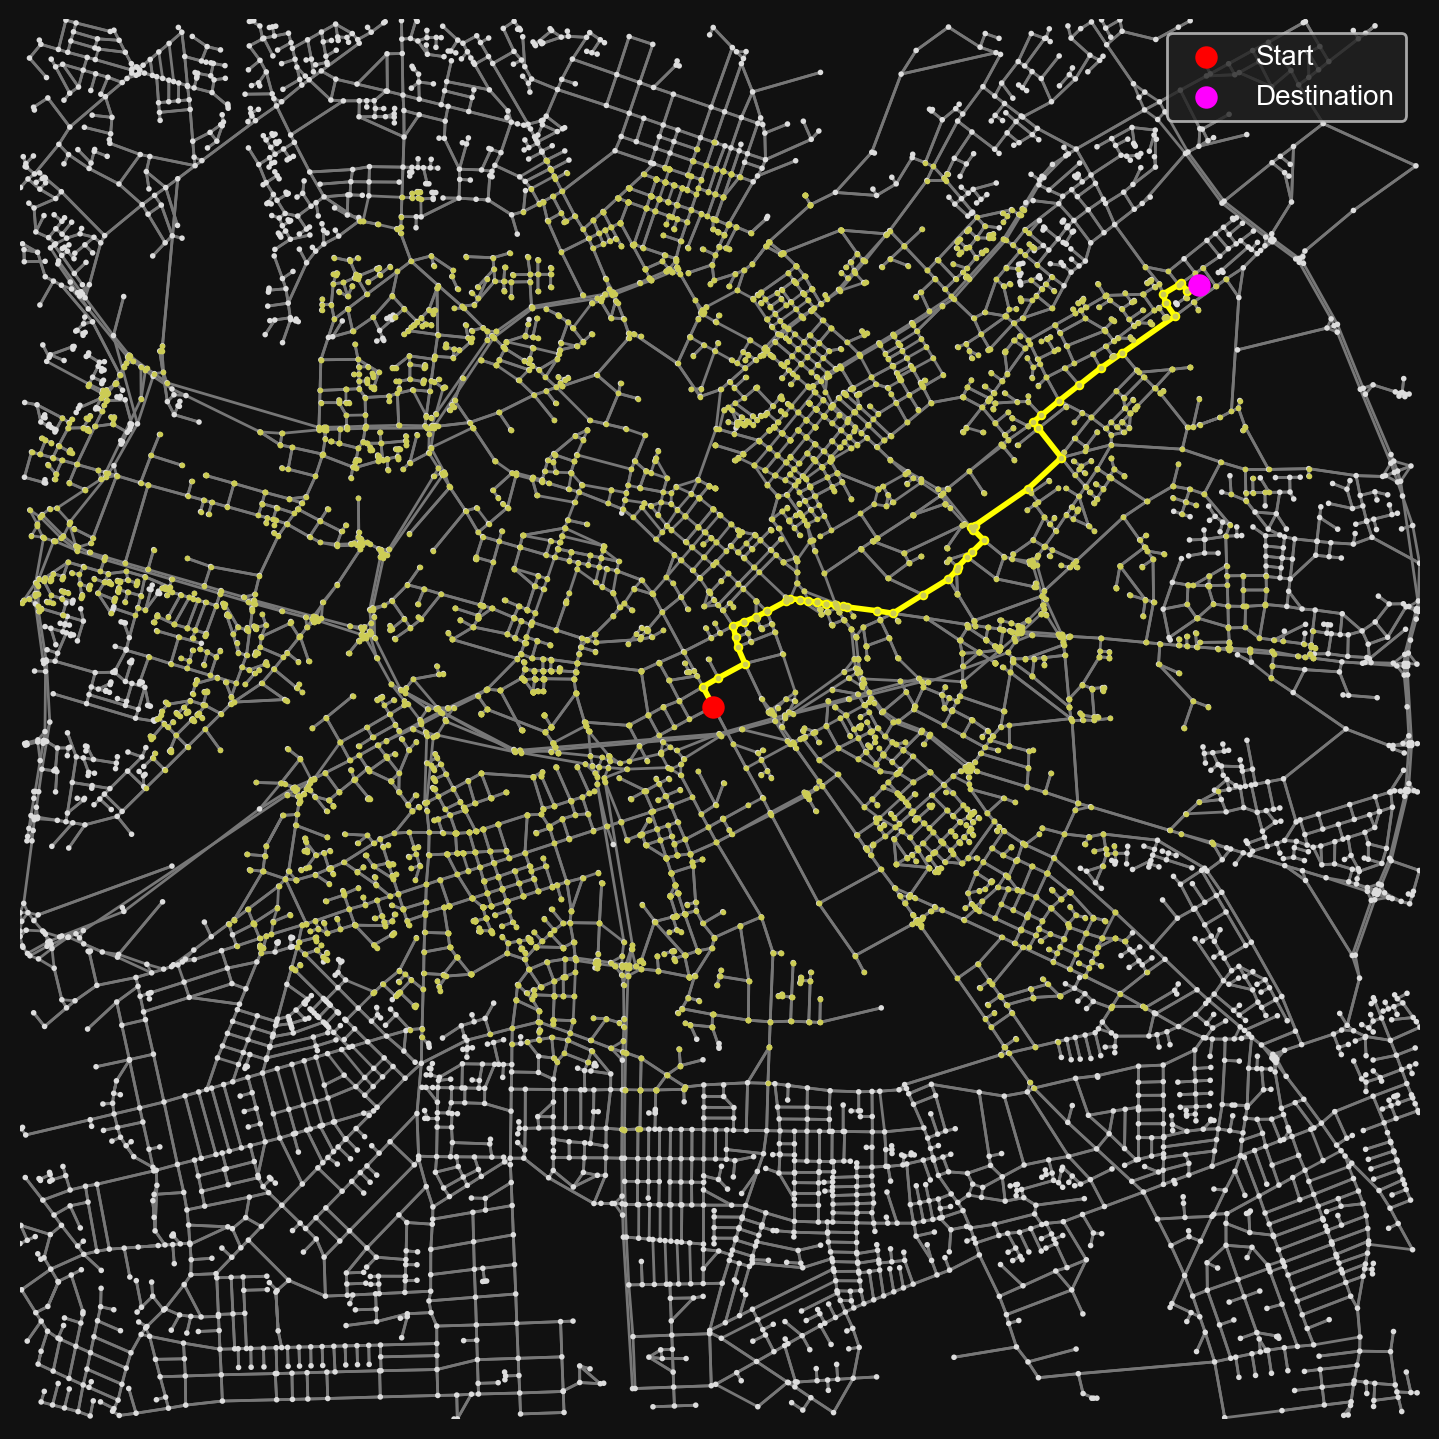

In [66]:
# Run a search with each algorithm

for method in SearchType:
    start_time = time.time()
    searcher.run_search(search_type=method)
    
    print(f"{method.name} search took {format_time(time.time() - start_time)}")
    print(f"Visited {len(searcher.closed)} nodes.")
    searcher.display_final()

In [67]:
for method in SearchType:
    searcher.animate_search(search_type=method)

Saving output to BFS_manchester.mp4.
Visited 6491 nodes
Saving output to DFS_manchester.mp4.
Visited 4848 nodes
Saving output to UCS_manchester.mp4.


KeyboardInterrupt: 

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>Breadth First
        <br>
        <video src="BFS_manchester.mp4" alt="bfs" width="500" controls/>
    </div>\

  <div style="flex: 50%;">
        <h1>Depth First
        <br>
        <video src="DFS_manchester.mp4" alt="dfs" width="500" controls/>
    </div>
</div>

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>UCS
        <br>
        <video src="UCS_manchester.mp4" alt="bfs" width="500" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>A*
        <br>
        <video src="A_STAR_manchester.mp4" alt="dfs" width="500" controls />
    </div>
</div>

# Evaluation

In [46]:
from pretty_progress import progress_bar

n_trials = 50

results_df = pd.DataFrame({
    "Distance": np.zeros(n_trials),
    "DFS_Time": np.zeros(n_trials),
    "BFS_Time": np.zeros(n_trials),
    "UCS_Time": np.zeros(n_trials),
    "A_Star_Time": np.zeros(n_trials),
    "DFS_Journey_Time": np.zeros(n_trials),
    "BFS_Journey_Time": np.zeros(n_trials),
    "UCS_Journey_Time": np.zeros(n_trials),
    "A_Star_Journey_Time": np.zeros(n_trials),
})

# Run the search n times
for i in range(n_trials):
    progress_bar(i, n_trials)

    start = start_node
    end = random.choice(nodes)
    print("Navigating to", nodes.index(end))

    searcher = SearchClass(start_node, end, heuristic_func=distance_normalised)

    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.BFS)
    bfs_duration =  time.time_ns() - start_time
    bfs_journey_time = searcher.closed[-1].cost_to_reach

    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.DFS)
    dfs_duration = time.time_ns() - start_time
    dfs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.UCS)
    ucs_duration = time.time_ns() - start_time
    ucs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.A_STAR)
    a_star_duration = time.time_ns() - start_time
    a_star_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    # Fill row
    results_df.loc[i] = [euclid_distance(start, end)/1e3, 
                         dfs_duration / 1e6, 
                         bfs_duration / 1e6, 
                         ucs_duration / 1e6,
                         a_star_duration / 1e6, 
                         dfs_journey_time, 
                         bfs_journey_time, 
                         ucs_journey_time,
                         a_star_journey_time]

|--------------------------------------------------| 0%Navigating to 244
|#-------------------------------------------------| 2%Navigating to 152
|##------------------------------------------------| 4%Navigating to 63
|###-----------------------------------------------| 6%Navigating to 176
|####----------------------------------------------| 8%Navigating to 256
|#####---------------------------------------------| 10%Navigating to 36
|######--------------------------------------------| 12%Navigating to 19
|#######-------------------------------------------| 14%Navigating to 103
|########------------------------------------------| 16%Navigating to 167
|#########-----------------------------------------| 18%Navigating to 135
|##########----------------------------------------| 20%Navigating to 107
|###########---------------------------------------| 22%Navigating to 155
|############--------------------------------------| 24%Navigating to 159
|#############--------------------------------

In [ ]:
results_df.to_csv("results.csv")
results_df

Distance  DFS_Time  BFS_Time  UCS_Time  A_Star_Time  DFS_Journey_Time  \
0   5952.997741     5.282     6.898    80.559       45.248        440.991156   
1   5952.912382     0.277     4.782   102.987       64.841        322.142615   
2   5952.167558     1.111     3.545    83.582       52.952        621.274662   
3   5951.963499     2.040     2.205    72.603       34.953        674.958474   
4   5952.456063     1.291    12.999   155.247      144.963        675.503476   
5   5951.926574     0.103    11.578   111.752       63.835        157.616980   
6   5952.457488     0.589     0.060     9.435        7.816        496.828316   
7   5952.280825     1.091     5.793   147.822      102.164        643.889487   
8   5952.726891     4.000     2.060    75.326       47.410        514.224442   
9   5952.297155     1.667     3.716    66.951       33.258        601.438853   
10  5952.009151     2.428     4.754    80.043       43.376        696.011504   
11  5952.334703     0.604     0.071     9.534        4.967        477.455121   
12  5952.754765     2.993     0.255    23.737       14.286        635.193539   
13  5952.290398     0.583     0.179    16.026       12.147        466.780828   
14  5952.570332     0.698     0.050     9.809        7.425        537.856395   
15  5952.163884     1.841     3.148    24.574       15.656        643.303907   
16  5952.137245     0.939     2.067    79.957       42.367        612.291395   
17  5952.863034     5.422    12.300   138.474      168.583        336.386749   
18  5952.256346     0.195     4.957    29.678       20.921        213.527225   
19  5952.006390     0.101     6.076    80.624       41.650        129.913566   
20  5952.060368     1.521     2.281    70.574       36.776        621.534366   
21  5952.986053     4.813     2.379    80.100       42.074        398.410893   
22  5952.234182     1.652     1.098    17.609       10.976        637.733916   
23  5952.910578     0.326     1.637    80.583       51.249        331.772984   
24  5952.997741     4.680     6.045    81.608       46.260        440.991156   
25  5952.872207     4.525     2.673    87.110       60.493        455.790994   
26  5952.270171     0.203     0.996    14.736       10.838        219.909366   
27  5952.427499     5.710    13.330   145.184      139.317        335.797509   
28  5952.153732     1.571     0.393    24.934       14.631        620.573413   
29  5952.865728     5.688    11.583   119.589       81.061        341.036634   
30  5952.894114     4.752     1.464    40.375       24.012        412.586892   
31  5952.581308     0.756     0.020     3.448        2.934        526.775301   
32  5952.360985     1.218    10.004   151.500      123.397        659.286500   
33  5952.391587     3.159     0.728    68.432       35.311        484.194323   
34  5952.789831     0.231     7.234   133.425      100.448        296.708010   
35  5952.183198     1.569     0.196    19.779       13.271        617.240755   
36  5952.661235     3.110     0.039     6.790        4.697        536.869001   
37  5952.814054     2.660     0.479    40.849       26.197        616.640963   
38  5952.360985     1.153     9.599   140.624      128.322        659.286500   
39  5952.377616     0.502     0.340    26.024       19.341        455.679901   
40  5952.271218     6.710     0.084    15.982        9.863         20.060012   
41  5952.880467     5.391    12.820   154.343       94.406        337.829353   
42  5952.073293     2.256     4.365    62.848       33.719        671.450160   
43  5952.377616     0.692     0.429    24.888       17.327        455.679901   
44  5952.166066     1.649     0.404    23.541       13.305        620.482424   
45  5952.247229     0.157    11.072    66.929       35.599        175.914321   
46  5952.758784     5.808     9.681   134.472      109.305        299.536570   
47  5952.608013     0.247     4.541   178.813       86.297        280.235579   
48  5952.866363     0.378     1.075    55.738       39.432        342.202450   
49  595

In [48]:
results_df.describe()

Distance   DFS_Time   BFS_Time    UCS_Time  A_Star_Time  \
count    50.000000  50.000000  50.000000   50.000000    50.000000   
mean   5952.469972   2.139820   4.090160   69.524540    47.666660   
std       0.319166   1.951254   4.277632   50.003606    41.959096   
min    5951.926574   0.101000   0.020000    3.448000     2.934000   
25%    5952.237444   0.592750   0.410250   23.946250    14.372250   
50%    5952.384602   1.545000   2.330000   69.503000    36.187500   
75%    5952.782069   3.146750   6.068250   99.017750    62.999500   
max    5952.997741   6.710000  13.330000  178.813000   168.583000   

       DFS_Journey_Time  BFS_Journey_Time  UCS_Journey_Time  \
count         50.000000               0.0         50.000000   
mean         465.496623               NaN         58.953581   
std          169.883515               NaN         29.386397   
min           20.060012               NaN          8.570156   
25%          336.747400               NaN         31.136808   
50%          480.824722               NaN         63.877385   
75%          620.550666               NaN         78.931674   
max          696.011504               NaN        120.125992   

       A_Star_Journey_Time  
count            50.000000  
mean             58.953581  
std              29.386397  
min               8.570156  
25%              31.136808  
50%              63.877385  
75%              78.931674  
max             120.125992

In [49]:
results_df.describe()[["DFS_Time", "BFS_Time", "A_Star_Time"]].loc["mean"]

DFS_Time        2.13982
BFS_Time        4.09016
A_Star_Time    47.66666
Name: mean, dtype: float64

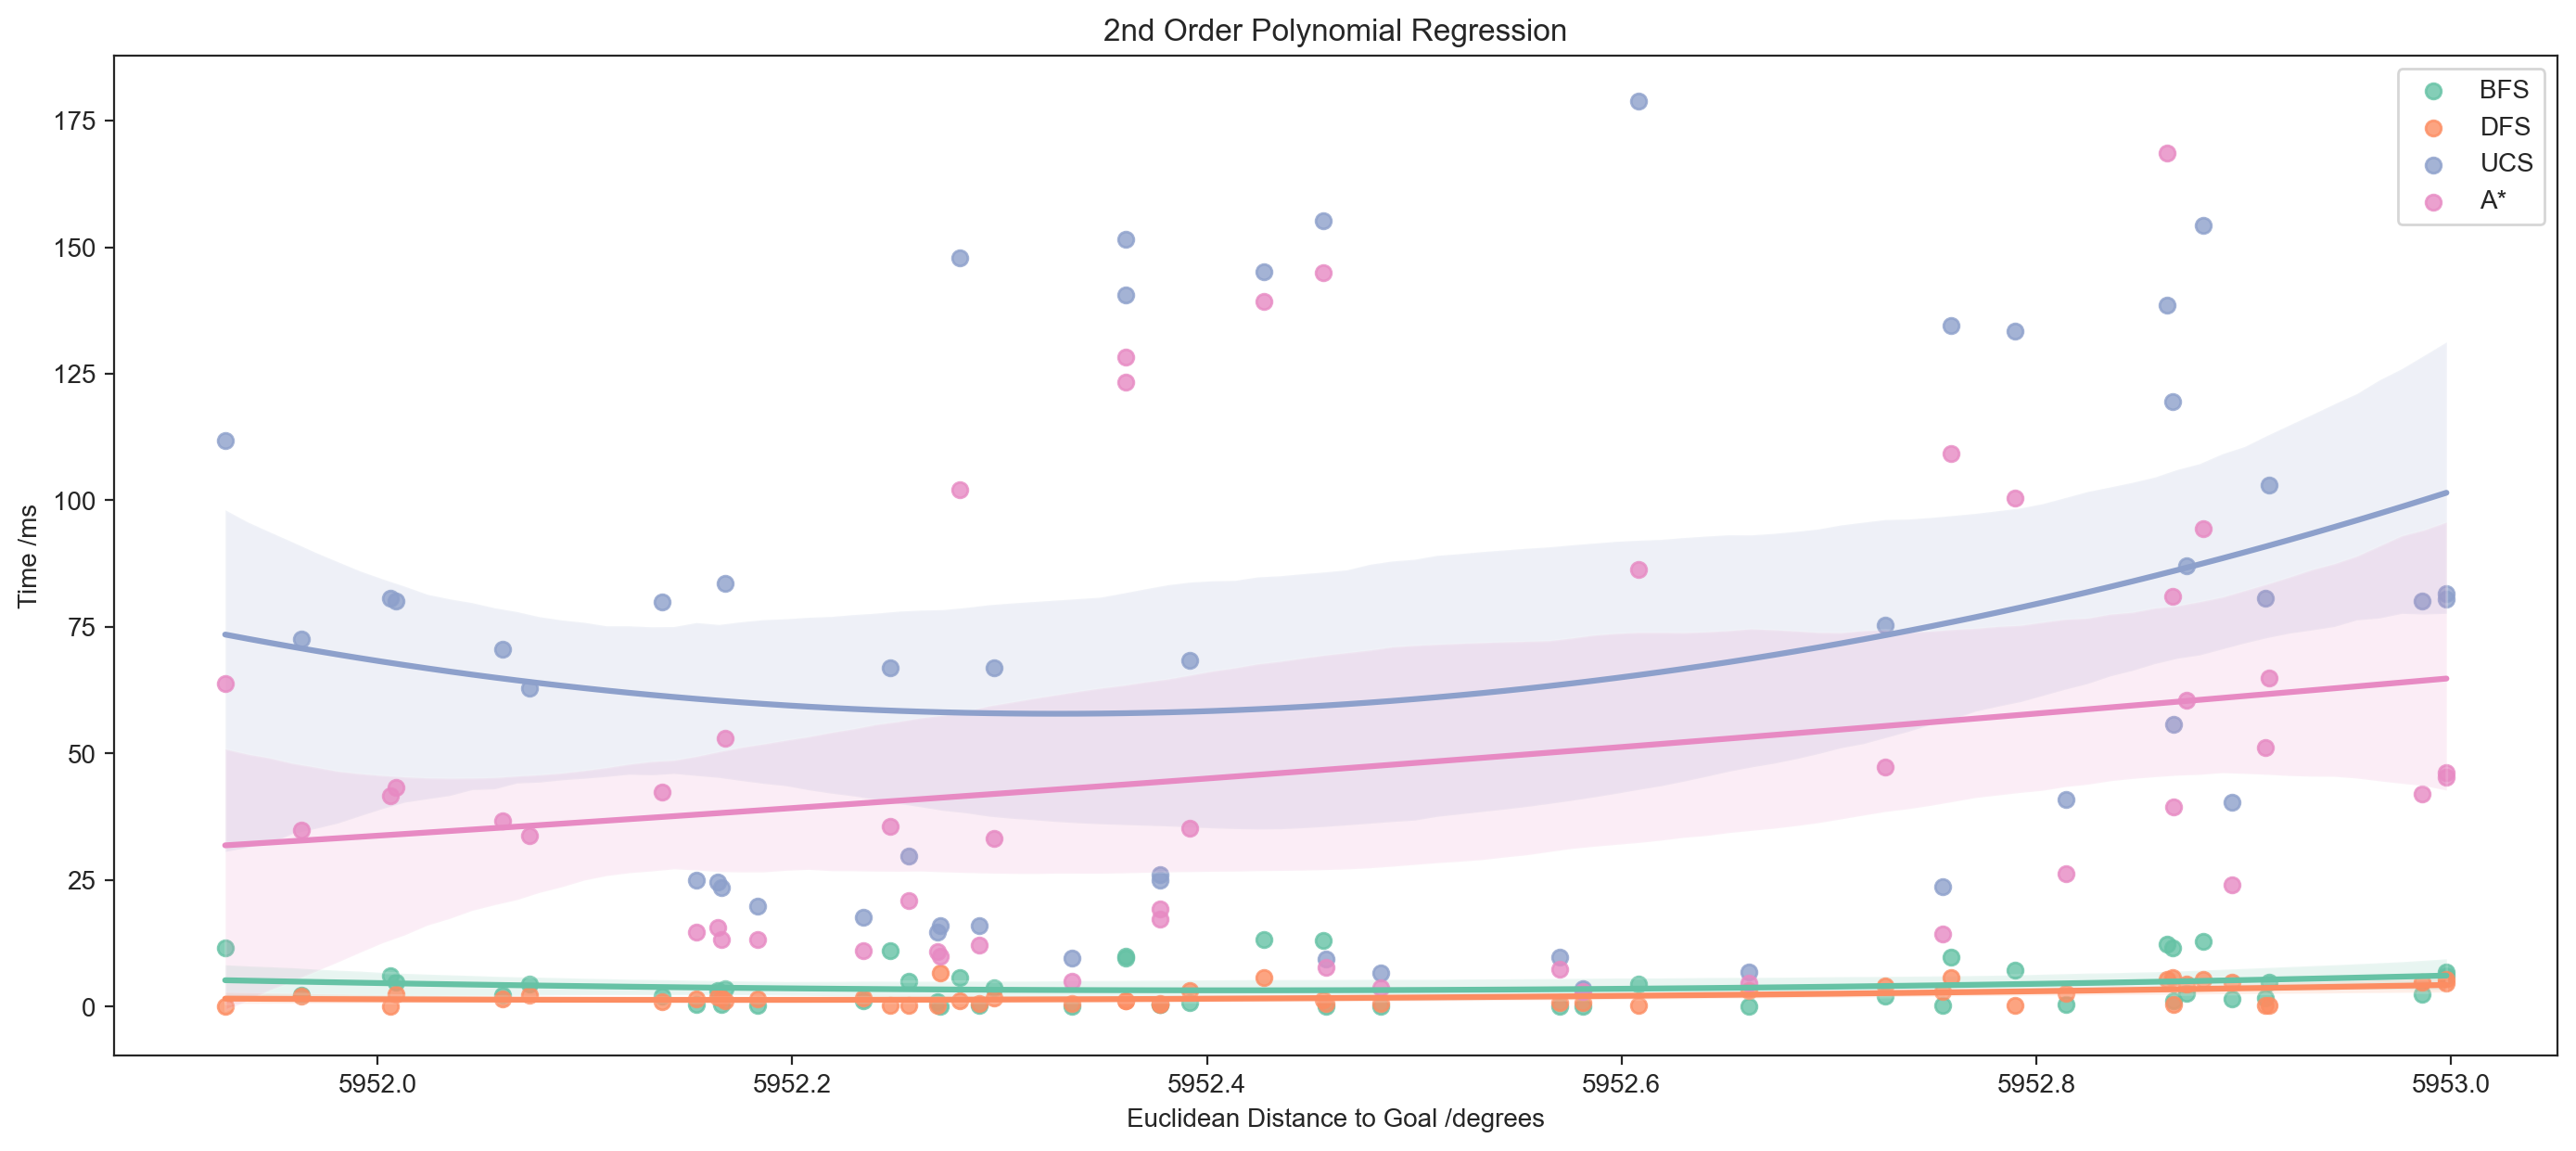

In [ ]:
sns.regplot(results_df, x="Distance", y="BFS_Time", order=2, ci=95, label="BFS")
sns.regplot(results_df, x="Distance", y="DFS_Time", order=2, ci=95, label="DFS")
sns.regplot(results_df, x="Distance", y="UCS_Time", order=2, ci=95, label="UCS")
sns.regplot(results_df, x="Distance", y="A_Star_Time", order=2, ci=95, label="A*")

# Customize the plot
plt.xlabel("Euclidean Distance to Goal /degrees")
plt.ylabel("Time /ms")
plt.title("2nd Order Polynomial Regression")
plt.legend()
plt.show()